In [194]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from alphacsc import GreedyCDL
from alphacsc.utils import split_signal
from scipy import signal
from scipy.signal import butter, filtfilt
from matplotlib import gridspec
import time

In [195]:
def butter_lowpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

def butter_highpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y

In [ ]:
VIS_FILTER = True
if VIS_FILTER:         
    
    filt0rder         = 10
    Wn                = 5 #Hz
    b, a = signal.butter(filt0rder, Wn, 'hp', analog=True)
    w, h = signal.freqs(b, a)
    plt.figure(figsize=(5, 4))
    plt.semilogx(w, 20 * np.log10(abs(h)), 'r')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(Wn, color='green') # cutoff frequency
    plt.show()
    

In [196]:
#filepath = '/data/sheng/MEG_source_data/case_0390/set2/parcel_ts/set2_parc2018yeo17_200_1000_weighted.npy'
filepath = '/data/sheng/MEG_source_data/case_0390/set3/parcel_ts/set3_parc2018yeo17_200_1000_weighted.npy'
#filepath = '/data/sheng/MEG_source_data/case_0390/set4/parcel_ts/set4_parc2018yeo17_200_1000_weighted.npy'

ori_fs             = 1000 # Original sampling rate (Hz)
decimate           = 10
parcelTS           = np.load(filepath) # data: channels x samples
print('MEG source time series dimension: ', parcelTS.shape)

MEG source time series dimension:  (200, 603000)


In [226]:
PARC_ID          = 65
aParcelTS        = parcelTS[PARC_ID]
fs               = ori_fs // decimate

LOW_PASS             = 30   #Hz
HI_PASS              = 0.5  #Hz 
lowpass_data         = butter_lowpass(aParcelTS, LOW_PASS, ori_fs)
highpass             = butter_highpass(lowpass_data, HI_PASS, ori_fs)
data                 = signal.decimate(highpass, decimate)
del lowpass_data
print(aParcelTS.shape, highpass.shape, data.shape)

'''
filt0rder        = 10
Wn               = 1 # Hz
sos              = signal.butter(filt0rder, Wn, 'hp', fs=ori_fs, output='sos')
highpass         = signal.sosfilt(sos, aParcelTS)
data             = signal.decimate(highpass, decimate)

'''

(603000,) (603000,) (60300,)


"\nfilt0rder        = 10\nWn               = 1 # Hz\nsos              = signal.butter(filt0rder, Wn, 'hp', fs=ori_fs, output='sos')\nhighpass         = signal.sosfilt(sos, aParcelTS)\ndata             = signal.decimate(highpass, decimate)\n\n"

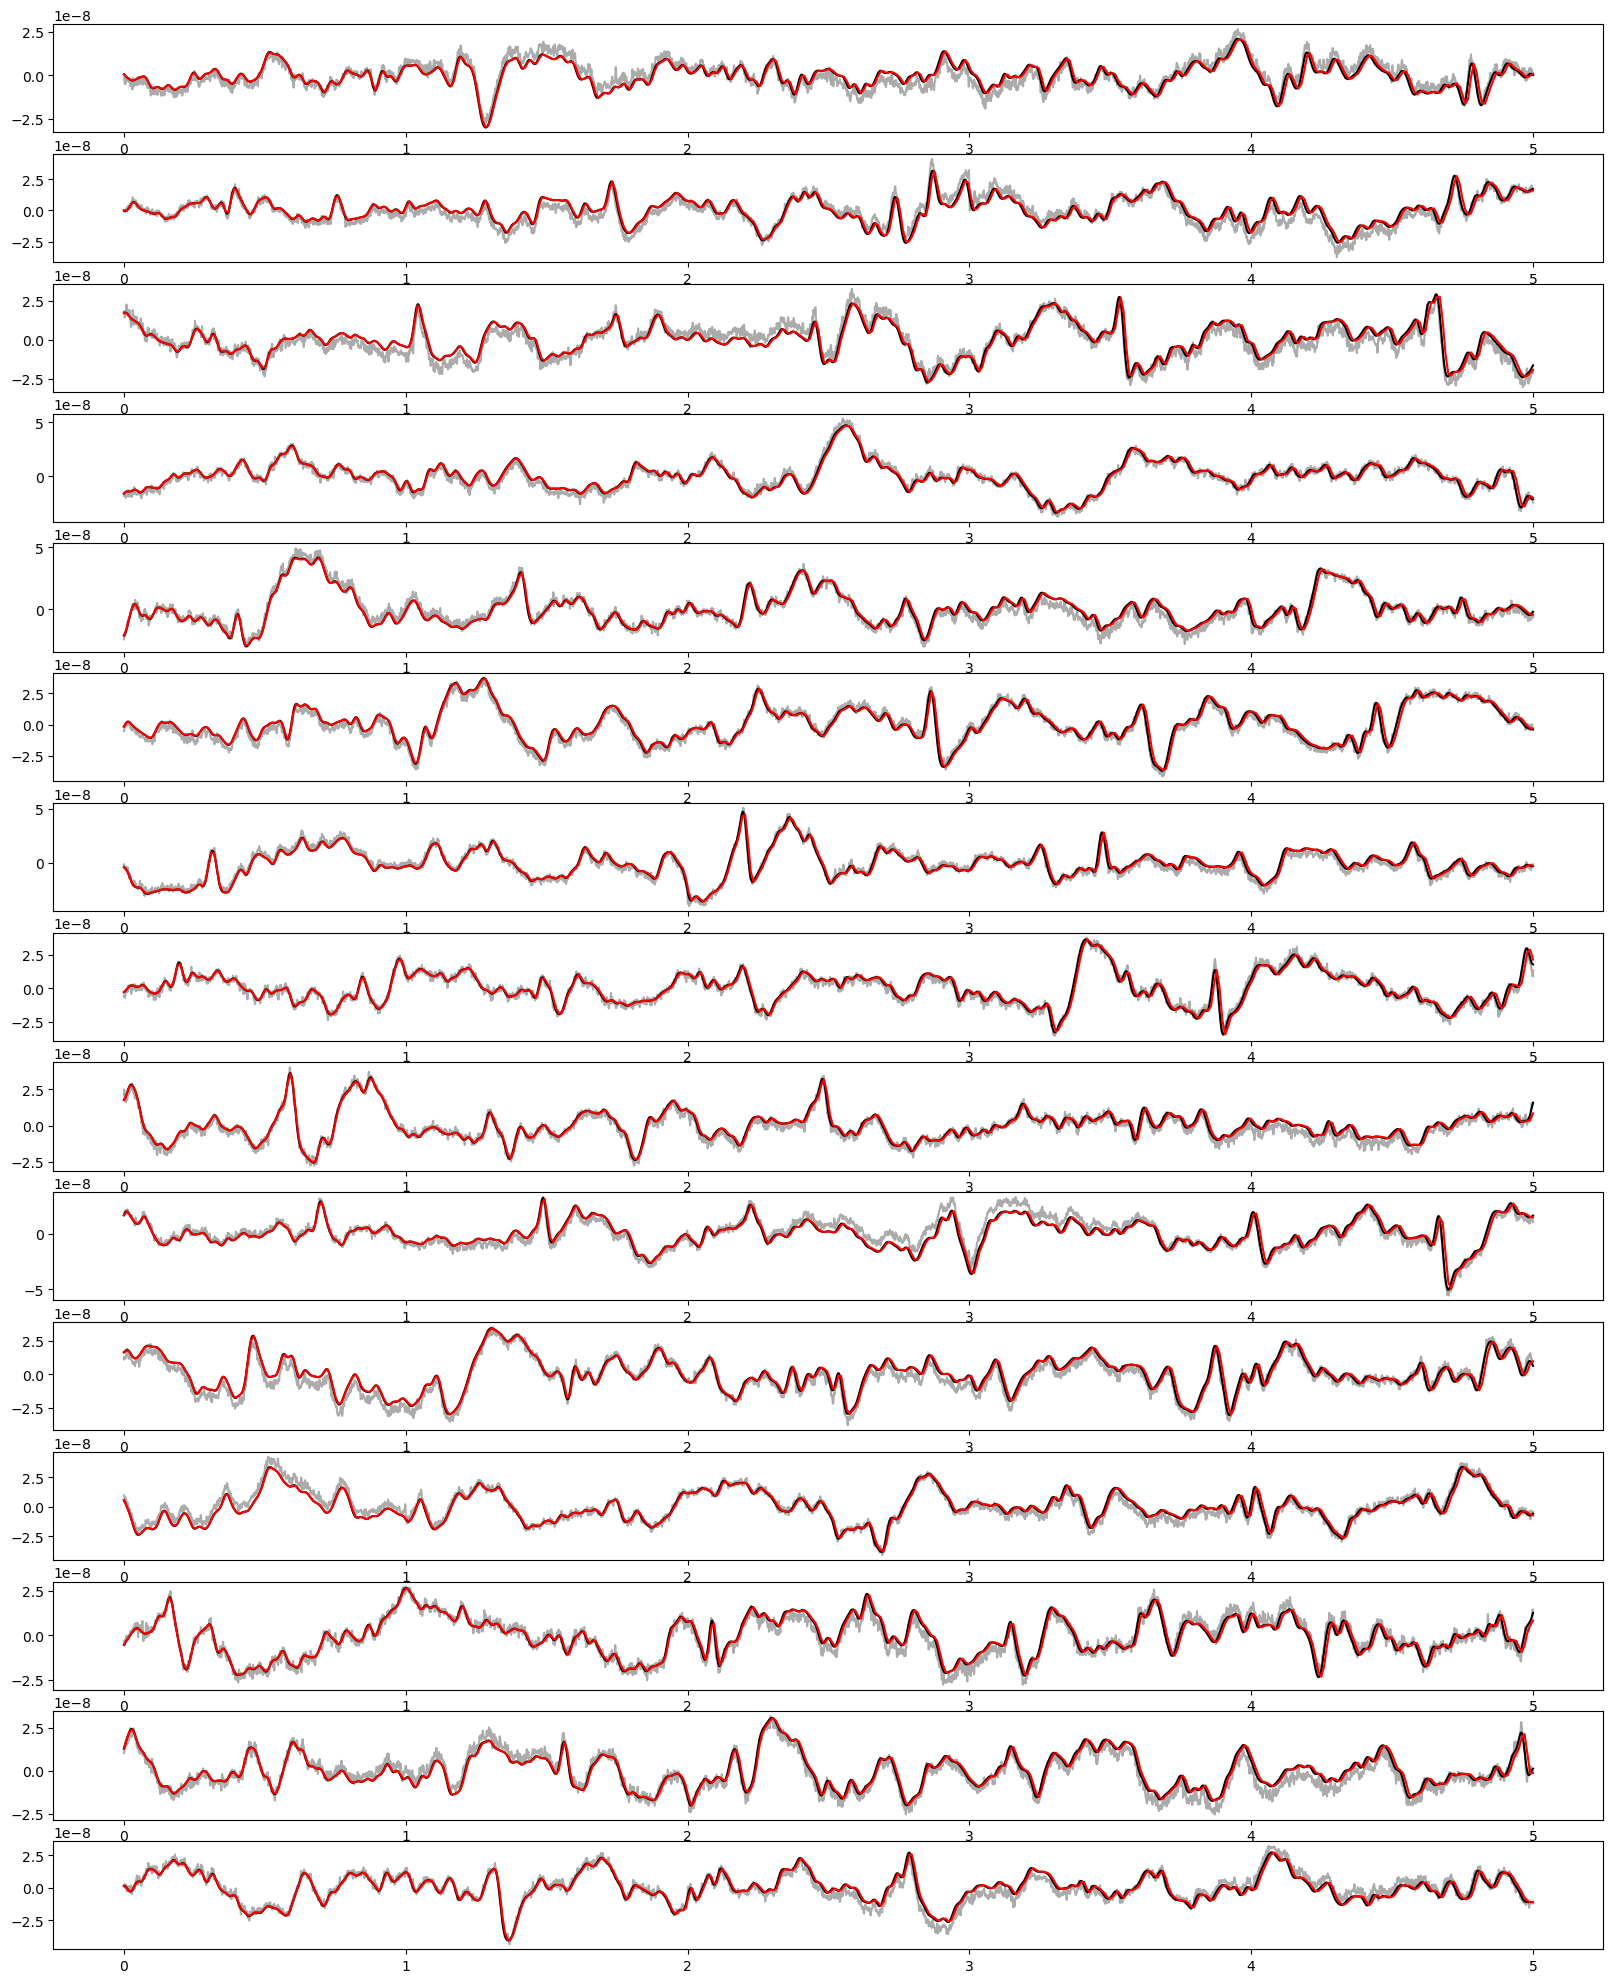

In [227]:
BLOCK_SIZE = 5 # Seconds
BLOCK_N    = 15
plt.figure(figsize=(20, 25))
for i in range(BLOCK_N):
    plt.subplot(BLOCK_N, 1, i+1)
    
    # gray: orig TS
    plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
             aParcelTS[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k', alpha=0.33)
    
    # black: filtered data
    plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
             highpass[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k')
    
    # red: filtered and decimated
    plt.plot(np.linspace(0, BLOCK_SIZE, fs*BLOCK_SIZE), data[i*fs*BLOCK_SIZE:(i+1)*fs*BLOCK_SIZE], 'r')
    

In [228]:
split_data = split_signal(data[None], 8)
split_data.shape

(8, 1, 7537)

In [ ]:

for i, d in enumerate(split_data):
    plt.figure(figsize=(12, 4))
    plt.subplot(split_data.shape[0], 1, i+1)
    plt.plot(d[0])
    plt.ylim([np.min(data), np.max(data)])
plt.show()

In [246]:
t1            = time.time()

# Univariate CDL
n_times_atom    = 3 * ori_fs // decimate  # aton duration (s)
n_atoms         = 5
N_JOBS          = 80
ITER_N          = 100 # or 150

print(n_times_atom)
cdl_opt = GreedyCDL(
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    reg=0.01,
    n_iter=ITER_N,
    n_jobs=N_JOBS,
    window=True,
)
cdl_opt.fit(split_data)
z_hat = cdl_opt.z_hat_
d_hat = cdl_opt.D_hat_


print('\nN of atoms: ', n_atoms, ', Num of Jobs: ', N_JOBS)
print('Low: ', LOW_PASS, 'Hz, High:', HI_PASS, 'Hz')
print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t2))}")

300
[GreedyCDL] CD iterations 0 / 100
[GreedyCDL] lambda = 2.415e-01
[GreedyCDL] Objective (z) : 1.128e+04 (sparsity: 2.230e-01)
[GreedyCDL] Objective (d) : 9.352e+03
[GreedyCDL] CD iterations 1 / 100
[GreedyCDL] Objective (z) : 6.080e+03 (sparsity: 1.522e-01)
[GreedyCDL] Objective (d) : 5.696e+03
[GreedyCDL] CD iterations 2 / 100
[GreedyCDL] Objective (z) : 4.944e+03 (sparsity: 1.146e-01)
[GreedyCDL] Objective (d) : 4.704e+03
[GreedyCDL] CD iterations 3 / 100
[GreedyCDL] Objective (z) : 4.359e+03 (sparsity: 9.266e-02)
[GreedyCDL] Objective (d) : 4.170e+03
[GreedyCDL] CD iterations 4 / 100
[GreedyCDL] Objective (z) : 3.947e+03 (sparsity: 8.015e-02)
[GreedyCDL] Objective (d) : 3.849e+03
[GreedyCDL] CD iterations 5 / 100
[GreedyCDL] Objective (z) : 3.787e+03 (sparsity: 8.360e-02)
[GreedyCDL] Objective (d) : 3.737e+03
[GreedyCDL] CD iterations 6 / 100
[GreedyCDL] Objective (z) : 3.687e+03 (sparsity: 8.638e-02)
[GreedyCDL] Objective (d) : 3.649e+03
[GreedyCDL] CD iterations 7 / 100
[Greedy

[GreedyCDL] Objective (d) : 3.318e+03
[GreedyCDL] CD iterations 62 / 100
[GreedyCDL] Objective (z) : 3.317e+03 (sparsity: 1.202e-01)
[GreedyCDL] Objective (d) : 3.317e+03
[GreedyCDL] CD iterations 63 / 100
[GreedyCDL] Objective (z) : 3.317e+03 (sparsity: 1.205e-01)
[GreedyCDL] Objective (d) : 3.316e+03
[GreedyCDL] CD iterations 64 / 100
[GreedyCDL] Objective (z) : 3.316e+03 (sparsity: 1.208e-01)
[GreedyCDL] Objective (d) : 3.316e+03
[GreedyCDL] CD iterations 65 / 100
[GreedyCDL] Objective (z) : 3.315e+03 (sparsity: 1.210e-01)
[GreedyCDL] Objective (d) : 3.315e+03
[GreedyCDL] CD iterations 66 / 100
[GreedyCDL] Objective (z) : 3.314e+03 (sparsity: 1.213e-01)
[GreedyCDL] Objective (d) : 3.314e+03
[GreedyCDL] CD iterations 67 / 100
[GreedyCDL] Objective (z) : 3.314e+03 (sparsity: 1.216e-01)
[GreedyCDL] Objective (d) : 3.313e+03
[GreedyCDL] CD iterations 68 / 100
[GreedyCDL] Objective (z) : 3.313e+03 (sparsity: 1.219e-01)
[GreedyCDL] Objective (d) : 3.313e+03
[GreedyCDL] CD iterations 69 / 

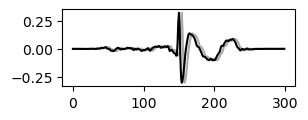

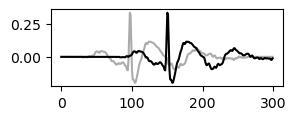

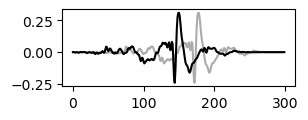

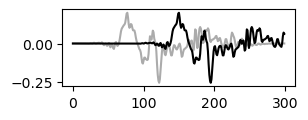

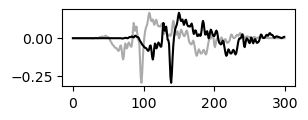

In [247]:
# Center the atoms for plotting

shifted_D = []
shifted_Z = []
for i, d in enumerate(d_hat[:, 0]):
    rolled = np.roll(d, len(d)//2-np.argmax(d))
    rolled_z = np.roll(z_hat[:, i], -(len(d)//2-np.argmax(d)), axis=-1)
    if np.argmax(d) < len(d)//2:
        rolled[:len(d)//2-np.argmax(d)] = 0
        rolled_z[:, -(len(d)//2-np.argmax(d)):] = 0
    else:
        rolled[len(d)//2-np.argmax(d):] = 0
        rolled_z[:, :-(len(d)//2-np.argmax(d))] = 0
    shifted_Z.append(rolled_z)
    shifted_D.append(rolled)
    
shifted_D = np.array(shifted_D)[:, None]
shifted_Z = np.moveaxis(shifted_Z, 0, 1)


for i in range(n_atoms):
    plt.figure(figsize=(3, 1))
    plt.plot(shifted_D[i][0], 'k')
    plt.plot(d_hat[i][0], 'k', alpha=0.33)
plt.show()

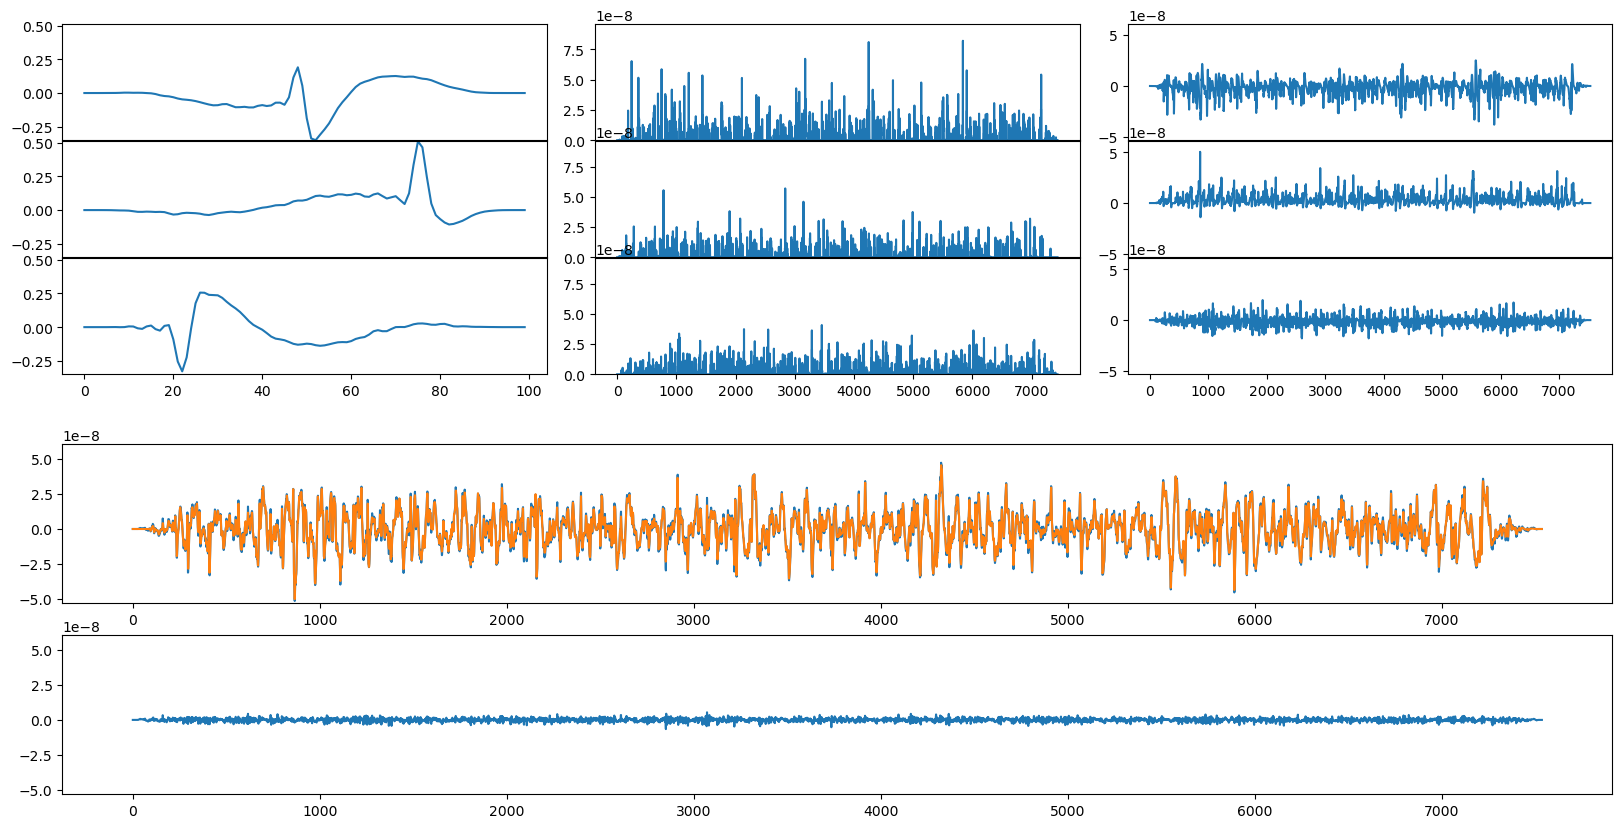

In [235]:
for myslice in [5]:
    fig = plt.figure(figsize=(20, 10))
    g = gridspec.GridSpec(2, 1, figure=fig)

    gg = g[0].subgridspec(n_atoms, 3, hspace=0.01, wspace=0.1)
    sig = []
    for i in range(n_atoms):
        ax = fig.add_subplot(gg[i, 0])
        ax.plot(d_hat[i][0])
        ax.set_ylim([np.min(d_hat), np.max(d_hat)])
        ax = fig.add_subplot(gg[i, 1])
        ax.plot(z_hat[myslice, i])
        ax.set_ylim([np.min(z_hat), np.max(z_hat)])
        ax = fig.add_subplot(gg[i, 2])
        sig.append(np.convolve(d_hat[i, 0], z_hat[myslice, i], mode='full'))
        ax.plot(sig[-1])
        ax.set_ylim([np.min(split_data), np.max(split_data)])

    gg = g[1].subgridspec(2, 1)
    ax = fig.add_subplot(gg[0])
    ax.plot(split_data[myslice, 0])
    est = np.sum(sig, axis=0)
    ax.set_ylim([np.min(split_data), np.max(split_data)])
    ax.plot(est)
    ax = fig.add_subplot(gg[1])
    ax.plot(split_data[myslice, 0] - est)
    ax.set_ylim([np.min(split_data), np.max(split_data)])


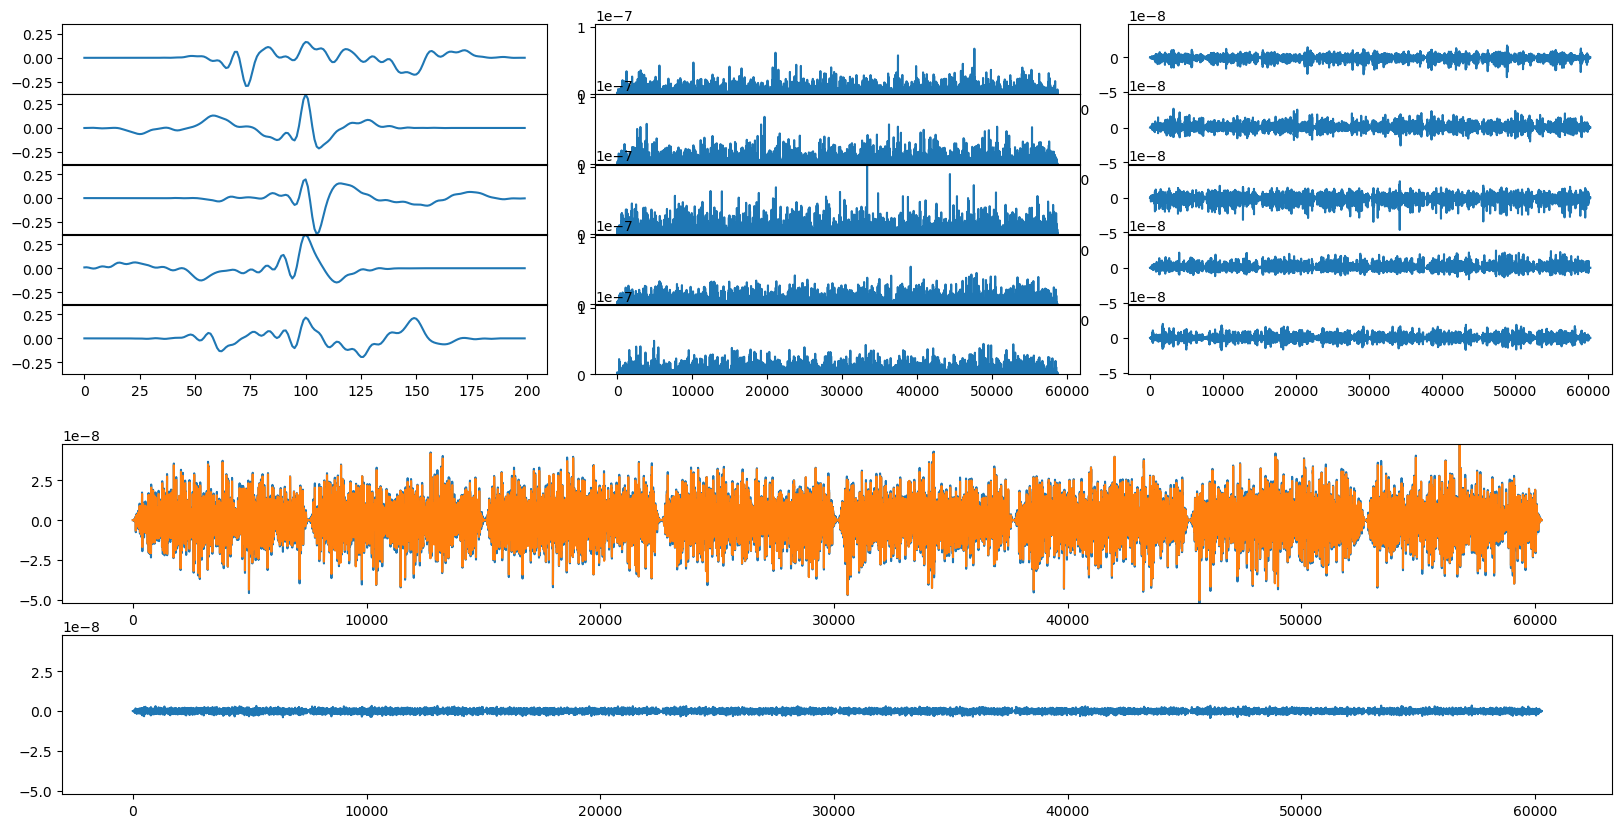

In [224]:
for myslice in [6]:
    fig = plt.figure(figsize=(20, 10))
    g = gridspec.GridSpec(2, 1, figure=fig)

    gg = g[0].subgridspec(n_atoms, 3, hspace=0.01, wspace=0.1)
    sig = []
    for i in range(n_atoms):
        ax = fig.add_subplot(gg[i, 0])
        ax.plot(shifted_D[i][0])
        ax.set_ylim([np.min(shifted_D), np.max(shifted_D)])
        ax = fig.add_subplot(gg[i, 1])
        ax.plot(z_hat[:, i].flatten())
        ax.set_ylim([np.min(shifted_Z), np.max(shifted_Z)])
        ax = fig.add_subplot(gg[i, 2])
        sig.append(signal.fftconvolve(shifted_D[i, 0][None, :], shifted_Z[:, i], mode='full').flatten())
        ax.plot(sig[-1])
        ax.set_ylim([np.min(split_data), np.max(split_data)])

    gg = g[1].subgridspec(2, 1)
    ax = fig.add_subplot(gg[0])
    ax.plot(split_data[:, 0].flatten())
    est = np.sum(sig, axis=0)
    ax.set_ylim([np.min(split_data), np.max(split_data)])
    ax.plot(est)
    ax = fig.add_subplot(gg[1])
    ax.plot(split_data[:, 0].flatten() - est)
    ax.set_ylim([np.min(split_data), np.max(split_data)])


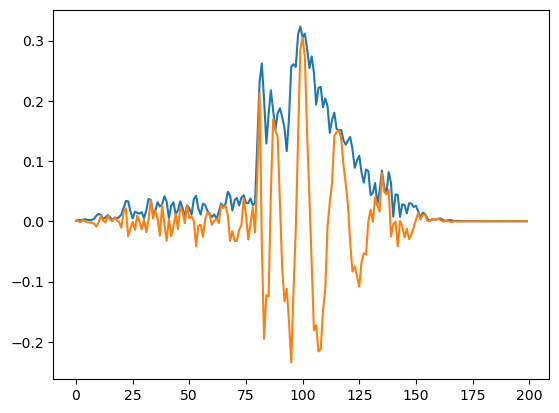

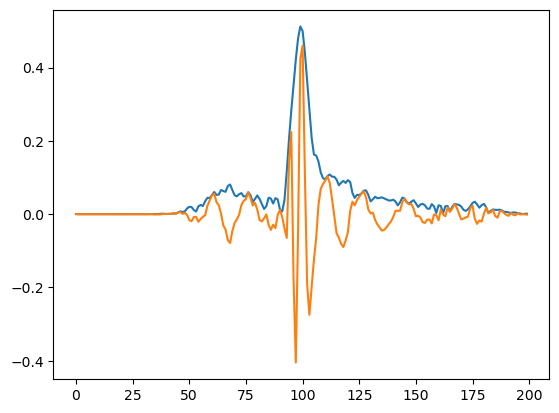

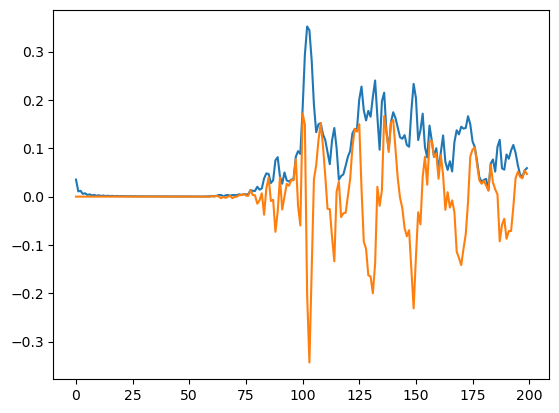

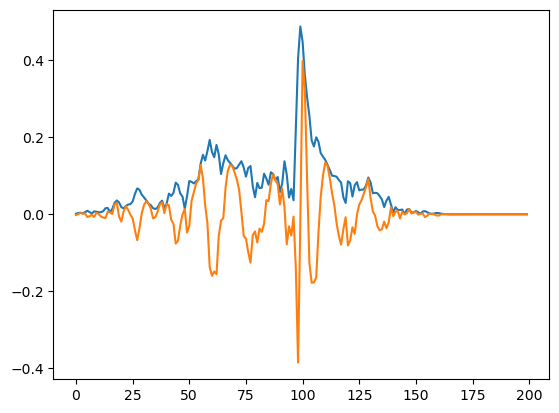

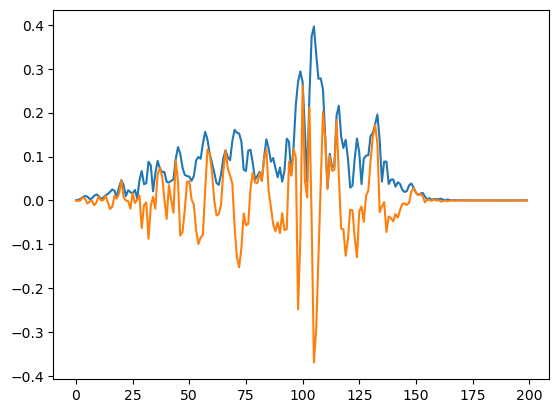

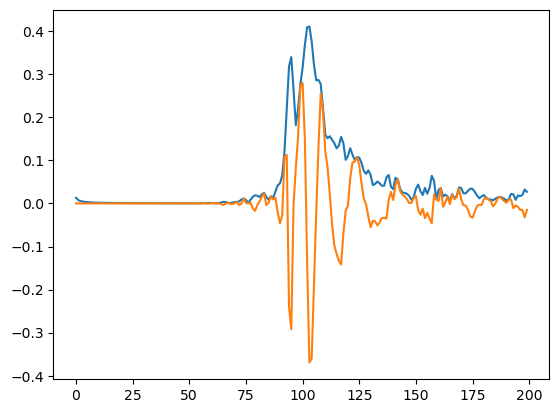

In [92]:
atom_ana = signal.hilbert(shifted_D[:, 0], axis=-1)
atom_phase = np.angle(atom_ana)

for i in range(n_atoms):
    plt.figure()
    plt.plot(np.abs(atom_ana[i]))
    plt.plot(shifted_D[i, 0])

In [60]:
import pickle as pkl
pkl.dump(cdl_opt, open("cdl_opt_final1.pkl", "wb"))

In [61]:
merged_Z = shifted_Z.swapaxes(0, 1).reshape(n_atoms, -1)
merged_data = split_data[:, 0].flatten()


In [62]:
from scipy.io import savemat 
savemat("cdl.mat", {"D": shifted_D, "Z": merged_Z, "data": merged_data, 'decomposed': est})

In [111]:
est.shape

(58336,)